# Improved Olympic Medal Predictions

This notebook implements several improvements over the basic linear regression model:
1. **Better feature engineering** - creating meaningful derived features
2. **Multiple models** - comparing Linear Regression, Random Forest, and Gradient Boosting
3. **Proper handling of missing values** - filling in prev_medals intelligently
4. **Cross-validation** - better evaluation of model performance
5. **Feature importance analysis** - understanding what drives medal counts

## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Prepare Data

In [ ]:
# Load data
teams = pd.read_csv("teams.csv")

print(f"Dataset shape: {teams.shape}")
print(f"\nMissing values: {teams.isnull().sum().sum()}")
teams.head()

Dataset shape: (2144, 11)

Missing values: 260


,team,country,year,events,athletes,age,height,weight,medals,prev_medals,prev_3_medals
0,AFG,Afghanistan,1964,8,8,22.0,161.0,64.2,0,0.0,0.0
1,AFG,Afghanistan,1968,5,5,23.2,170.2,70.0,0,0.0,0.0
2,AFG,Afghanistan,1972,8,8,29.0,168.3,63.8,0,0.0,0.0
3,AFG,Afghanistan,1980,11,11,23.6,168.4,63.2,0,0.0,0.0
4,AFG,Afghanistan,2004,5,5,18.6,170.8,64.8,0,0.0,0.0


## 3. Feature Engineering

Creating new features that might be predictive of medal counts:

In [ ]:
# Fill missing previous medal values with 0 (first-time participants)
teams['prev_medals'] = teams['prev_medals'].fillna(0)
teams['prev_3_medals'] = teams['prev_3_medals'].fillna(0)

# Create new features
teams['athletes_per_event'] = teams['athletes'] / teams['events']
teams['bmi'] = teams['weight'] / ((teams['height'] / 100) ** 2)
teams['medal_momentum'] = teams['prev_medals'] - teams['prev_3_medals'] / 3  # Recent performance trend
teams['experience_score'] = teams['prev_3_medals'] / teams['athletes']  # Medals per athlete historically
teams['team_efficiency'] = teams['prev_medals'] / (teams['athletes'] + 1)  # Avoid division by zero

# Create categorical features
teams['is_host'] = 0
teams['decade'] = (teams['year'] // 10) * 10

# Create interaction features for important variables
teams['athletes_x_prev_medals'] = teams['athletes'] * teams['prev_medals']
teams['events_x_prev_medals'] = teams['events'] * teams['prev_medals']

print("New features created:")
print(teams[['athletes_per_event', 'bmi', 'medal_momentum', 'experience_score', 'team_efficiency']].describe())

New features created:
       athletes_per_event          bmi  medal_momentum  experience_score  \
count         2144.000000  2144.000000     2144.000000       2144.000000   
mean             1.565775    22.864418        6.668361          0.047551   
std              0.729523     1.887303       22.311207          0.097601   
min              1.000000    16.560287       -5.333333          0.000000   
25%              1.000000    21.937687        0.000000          0.000000   
50%              1.310728    22.765764        0.000000          0.000000   
75%              1.959821    23.562292        2.000000          0.062008   
max             15.000000    48.326531      337.333333          2.185714   

       team_efficiency  
count      2144.000000  
mean          0.049105  
std           0.124290  
min           0.000000  
25%           0.000000  
50%           0.000000  
75%           0.056011  
max           3.125000  


## 4. Exploratory Data Analysis

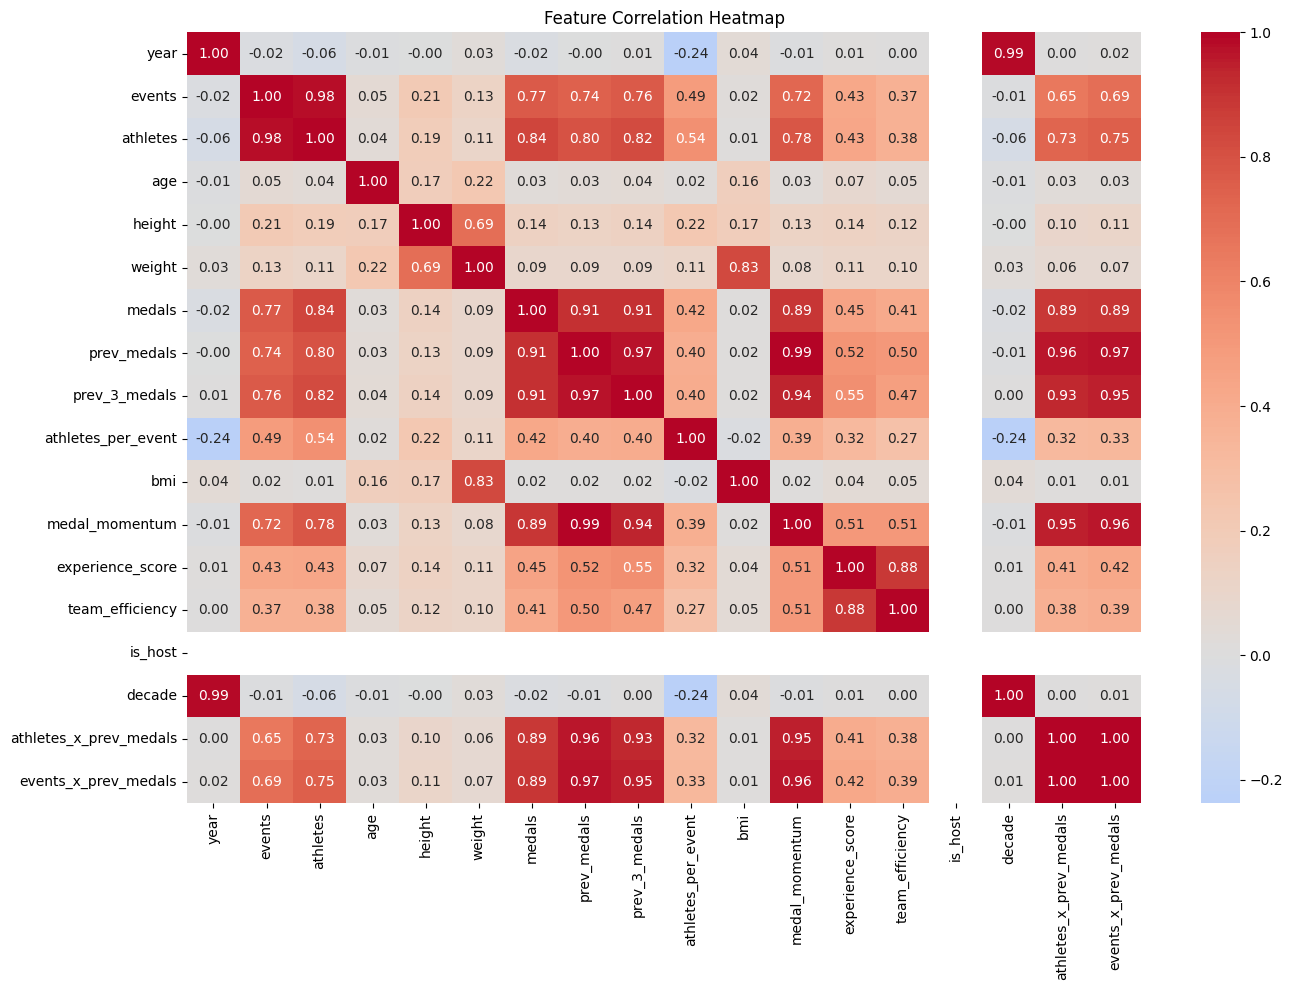


Top 10 features correlated with medals:
medals                    1.000000
prev_medals               0.909139
prev_3_medals             0.907482
medal_momentum            0.893565
events_x_prev_medals      0.890063
athletes_x_prev_medals    0.888283
athletes                  0.840817
events                    0.771330
experience_score          0.450715
athletes_per_event        0.424304
team_efficiency           0.406746
Name: medals, dtype: float64


In [ ]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
numeric_cols = teams.select_dtypes(include=[np.number]).columns
correlation = teams[numeric_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Top correlations with medals
medal_corr = correlation['medals'].sort_values(ascending=False)
print("\nTop 10 features correlated with medals:")
print(medal_corr.head(11))  # 11 to exclude medals itself

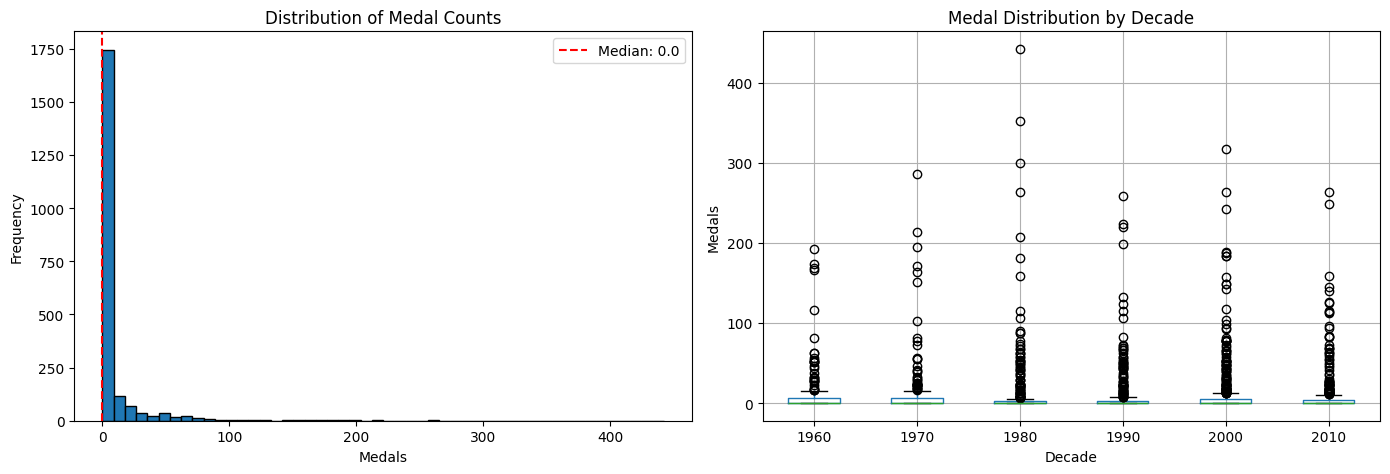

In [ ]:
# Distribution of medals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(teams['medals'], bins=50, edgecolor='black')
axes[0].set_xlabel('Medals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Medal Counts')
axes[0].axvline(teams['medals'].median(), color='red', linestyle='--', label=f'Median: {teams["medals"].median()}')
axes[0].legend()

# Box plot by decade
teams.boxplot(column='medals', by='decade', ax=axes[1])
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Medals')
axes[1].set_title('Medal Distribution by Decade')
plt.suptitle('')  # Remove the automatic title

plt.tight_layout()
plt.show()

## 5. Prepare Train/Test Split

We'll use 2012 and earlier for training, 2016 for testing

In [ ]:
# Time-based split
train = teams[teams['year'] < 2016].copy()
test = teams[teams['year'] == 2016].copy()

print(f"Training set: {len(train)} rows")
print(f"Test set: {len(test)} rows")

# Select features
feature_cols = [
    'athletes', 'events', 'age', 'height', 'weight',
    'prev_medals', 'prev_3_medals',
    'athletes_per_event', 'bmi', 'medal_momentum',
    'experience_score', 'team_efficiency',
    'athletes_x_prev_medals', 'events_x_prev_medals'
]

X_train = train[feature_cols]
y_train = train['medals']
X_test = test[feature_cols]
y_test = test['medals']

print(f"\nFeatures used: {len(feature_cols)}")
print(feature_cols)

Training set: 1940 rows
Test set: 204 rows

Features used: 14
['athletes', 'events', 'age', 'height', 'weight', 'prev_medals', 'prev_3_medals', 'athletes_per_event', 'bmi', 'medal_momentum', 'experience_score', 'team_efficiency', 'athletes_x_prev_medals', 'events_x_prev_medals']


## 6. Model Training and Comparison

We'll compare three models:
1. **Linear Regression** - Simple baseline
2. **Random Forest** - Handles non-linear relationships well
3. **Gradient Boosting** - Often provides best performance

In [ ]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Ensure non-negative predictions
    test_pred = np.maximum(0, test_pred)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()

    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_mae': cv_mae,
        'predictions': test_pred
    }

    print(f"\nTraining MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Training R²: {train_r2:.3f}")
    print(f"Test R²: {test_r2:.3f}")
    print(f"Cross-validation MAE: {cv_mae:.2f}")


Training Linear Regression...

Training MAE: 4.11
Test MAE: 3.51
Training RMSE: 11.05
Test RMSE: 9.10
Training R²: 0.890
Test R²: 0.903
Cross-validation MAE: 4.30

Training Random Forest...

Training MAE: 1.99
Test MAE: 3.30
Training RMSE: 5.21
Test RMSE: 8.86
Training R²: 0.976
Test R²: 0.908
Cross-validation MAE: 4.16

Training Gradient Boosting...

Training MAE: 1.19
Test MAE: 3.03
Training RMSE: 2.22
Test RMSE: 8.30
Training R²: 0.996
Test R²: 0.919
Cross-validation MAE: 4.20


In [ ]:
# Model comparison summary
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train MAE': [results[m]['train_mae'] for m in results],
    'Test MAE': [results[m]['test_mae'] for m in results],
    'Test RMSE': [results[m]['test_rmse'] for m in results],
    'Test R²': [results[m]['test_r2'] for m in results],
    'CV MAE': [results[m]['cv_mae'] for m in results]
})

comparison_df = comparison_df.sort_values('Test MAE')
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))
print("\nBest Model:", comparison_df.iloc[0]['Model'])


MODEL COMPARISON SUMMARY
            Model  Train MAE  Test MAE  Test RMSE  Test R²   CV MAE
Gradient Boosting   1.192282  3.032388   8.302302 0.918958 4.196671
    Random Forest   1.993292  3.300112   8.855062 0.907808 4.161392
Linear Regression   4.110531  3.511680   9.095480 0.902734 4.298977

Best Model: Gradient Boosting


## 7. Feature Importance Analysis

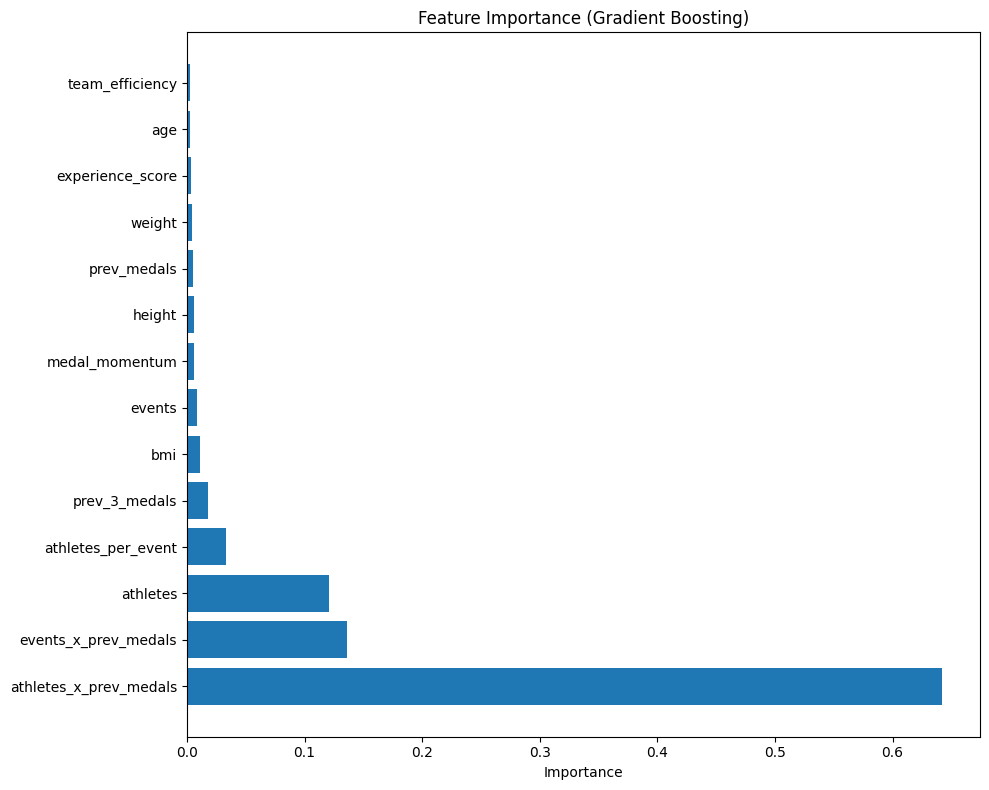


Top 10 Most Important Features:
               Feature  Importance
athletes_x_prev_medals    0.642285
  events_x_prev_medals    0.135991
              athletes    0.121007
    athletes_per_event    0.033497
         prev_3_medals    0.017556
                   bmi    0.011245
                events    0.008507
        medal_momentum    0.006365
                height    0.005940
           prev_medals    0.004827


In [ ]:
# Get feature importance from the best tree-based model
best_tree_model = results['Gradient Boosting']['model']  # or 'Gradient Boosting'

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_tree_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance (Gradient Boosting)')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 8. Prediction Analysis for 2016

In [ ]:
# Use the best performing model
best_model_name = comparison_df.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']

# Create results dataframe
test_results = test[['team', 'country', 'athletes', 'events', 'prev_medals', 'medals']].copy()
test_results['predicted_medals'] = best_predictions.round()
test_results['error'] = np.abs(test_results['medals'] - test_results['predicted_medals'])
test_results['error_ratio'] = test_results['error'] / (test_results['medals'] + 1)  # Avoid division by zero

# Top predictions
print("\n" + "="*70)
print("TOP 15 PREDICTED MEDAL WINNERS (2016)")
print("="*70)
print(test_results.nlargest(15, 'predicted_medals')[['country', 'medals', 'predicted_medals', 'error']].to_string(index=False))

# Worst predictions
print("\n" + "="*70)
print("TOP 10 LARGEST PREDICTION ERRORS")
print("="*70)
print(test_results.nlargest(10, 'error')[['country', 'medals', 'predicted_medals', 'error']].to_string(index=False))


TOP 15 PREDICTED MEDAL WINNERS (2016)
      country  medals  predicted_medals  error
United States     264             264.0    0.0
Great Britain     145             136.0    9.0
       Russia     115             131.0   16.0
        China     113             128.0   15.0
       Brazil      50             120.0   70.0
      Germany     159             120.0   39.0
    Australia      82             114.0   32.0
       France      96              70.0   26.0
        Japan      64              67.0    3.0
        Italy      72              66.0    6.0
        Spain      45              62.0   17.0
  South Korea      26              61.0   35.0
       Canada      69              60.0    9.0
  Netherlands      47              56.0    9.0
    Argentina      22              35.0   13.0

TOP 10 LARGEST PREDICTION ERRORS
    country  medals  predicted_medals  error
     Brazil      50             120.0   70.0
    Germany     159             120.0   39.0
South Korea      26              61.0   

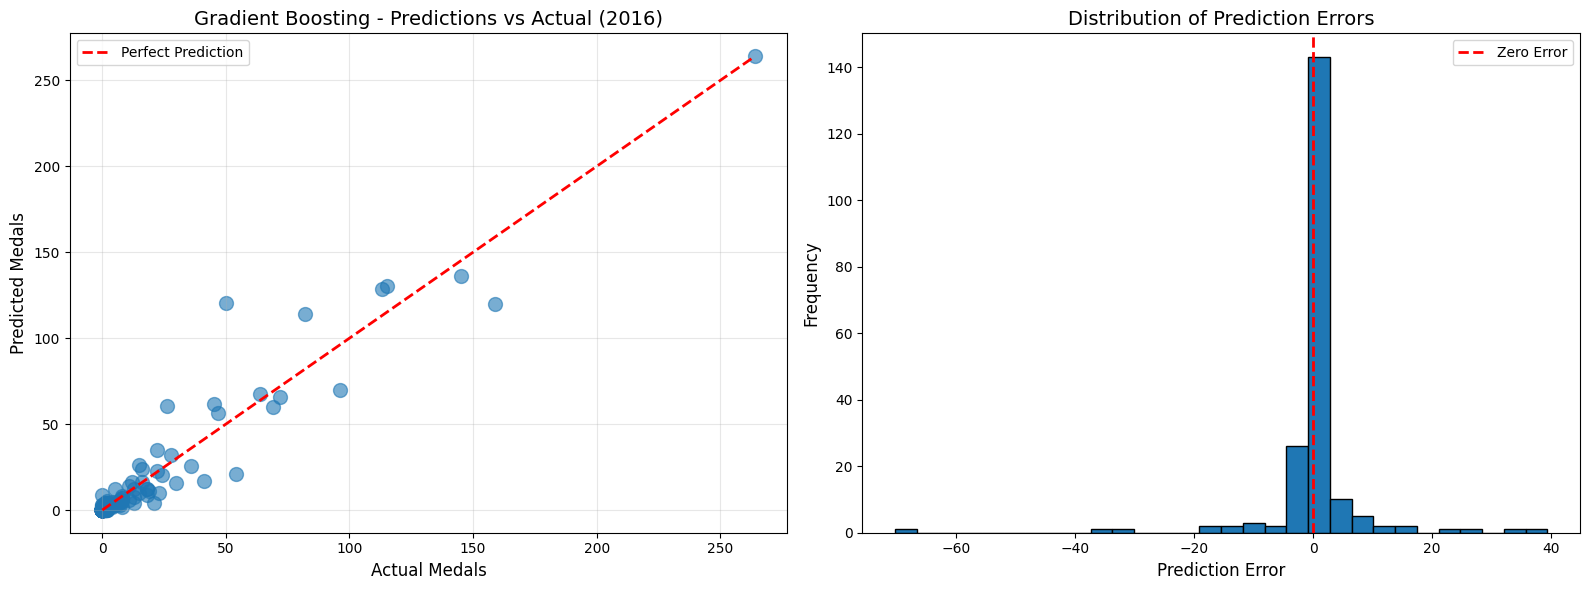


Error Statistics:
Mean Error: 0.02
Std Error: 8.32
Median Error: -0.04


In [ ]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_test, best_predictions, alpha=0.6, s=100)
axes[0].plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Medals', fontsize=12)
axes[0].set_ylabel('Predicted Medals', fontsize=12)
axes[0].set_title(f'{best_model_name} - Predictions vs Actual (2016)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error distribution
errors = y_test - best_predictions
axes[1].hist(errors, bins=30, edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', lw=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Prediction Errors', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

# Error statistics
print(f"\nError Statistics:")
print(f"Mean Error: {errors.mean():.2f}")
print(f"Std Error: {errors.std():.2f}")
print(f"Median Error: {np.median(errors):.2f}")

## 9. Error Analysis by Country Performance


Error Analysis by Medal Performance Category:
                      error               country
                       mean median    std   count
performance_category                             
No Medals              0.25    0.0   0.96     118
1-5 Medals             1.49    1.0   1.29      35
6-20 Medals            4.00    3.0   3.05      27
21-50 Medals          17.77   13.0  18.08      13
50+ Medals            17.09   15.0  13.36      11


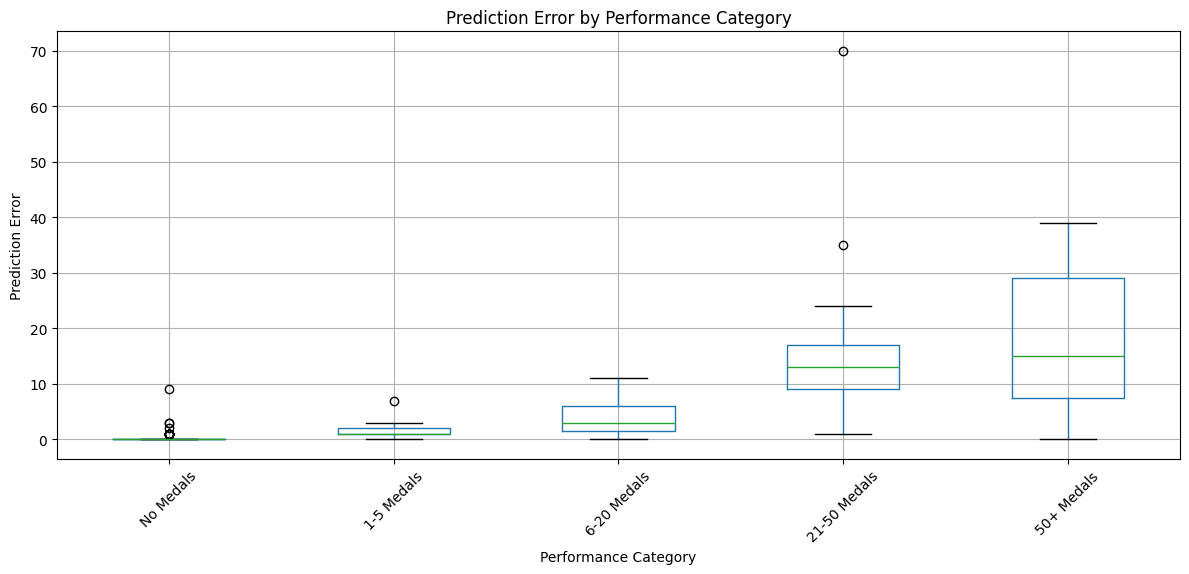

In [ ]:
# Categorize countries by actual performance
test_results['performance_category'] = pd.cut(
    test_results['medals'],
    bins=[-1, 0, 5, 20, 50, 1000],
    labels=['No Medals', '1-5 Medals', '6-20 Medals', '21-50 Medals', '50+ Medals']
)

# Error by category
category_error = test_results.groupby('performance_category').agg({
    'error': ['mean', 'median', 'std'],
    'country': 'count'
}).round(2)

print("\nError Analysis by Medal Performance Category:")
print(category_error)

# Box plot
plt.figure(figsize=(12, 6))
test_results.boxplot(column='error', by='performance_category', ax=plt.gca())
plt.xlabel('Performance Category')
plt.ylabel('Prediction Error')
plt.title('Prediction Error by Performance Category')
plt.suptitle('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Save Results and Model

In [ ]:
# Save predictions to CSV
test_results.to_csv('2016_predictions.csv', index=False)
print("Predictions saved to '2016_predictions.csv'")

# Summary statistics
print(f"\n{'='*70}")
print("FINAL SUMMARY")
print(f"{'='*70}")
print(f"Best Model: {best_model_name}")
print(f"Test MAE: {results[best_model_name]['test_mae']:.2f} medals")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.2f} medals")
print(f"Test R² Score: {results[best_model_name]['test_r2']:.3f}")
print(f"\nThis means on average, predictions are off by {results[best_model_name]['test_mae']:.2f} medals.")
print(f"The model explains {results[best_model_name]['test_r2']*100:.1f}% of the variance in medal counts.")

Predictions saved to '2016_predictions.csv'

FINAL SUMMARY
Best Model: Gradient Boosting
Test MAE: 3.03 medals
Test RMSE: 8.30 medals
Test R² Score: 0.919

This means on average, predictions are off by 3.03 medals.
The model explains 91.9% of the variance in medal counts.
